# Tutorial of TrajGPT on irreguarly-sampled time series in EHR data

In this notebook, we provide a tutorial about how to run **TrajGPT** for irregularly‐sampled time series, covering:

1. Data loading  
2. Model instantiation  
3. Pre‐training
4. Visualization by UMAP
5. Forecasting (auto‐regressive and time‐specific)  


<img src="figures/TrajGPT_architecture.png" alt="TrajGPT Architecture" width="800"/>


## 1. Data Loading 

We’ll use the bundled `data_pipeline` to load an EHR‐style CSV with `(value, timestamp)` pairs.


We present the longitudinal EHR dataset (e.g., PopHR) in the above form. Each row represents a single clinical event for a given patient with its occurred date. We can construct a series of clinical events by computing its age at diagnosis in a month-level.  As a result, this time-series representation use id to track all events for one individual as well as the the sequence of phenotypes over a patient’s life.


| Column             | Description                                                                                          |
|--------------------|------------------------------------------------------------------------------------------------------|
| **id**             | Unique patient identifier                                                                            |
| **date**           | Date of the clinical event (YYYY-MM-DD)                                                              |
| **icd**            | Original International Classification of Diseases (ICD) code assigned at that visit                  |
| **PheCode**        | Mapped “PheCode” (higher-level phenotype grouping)                                                   |
| **Phenotype**      | Human-readable description of the PheCode                                                            |
| **month_of_birth** | Patient’s date of birth (assumed to be the first day of the birth month)                             |
| **age_at_diag**    | Age at this diagnosis in months (i.e., months since birth to the event date)                         |



In [5]:
import torch
from torch.utils.data import DataLoader

In [2]:
import pandas as pd

# 1) Load the processed_pophr_data file
df = pd.read_csv('data/processed_pophr_data.csv')

# 2) Show the top 10 rows
df.head(10)

,id,date,icd,PheCode,Phenotype,month_of_birth,age_at_diag
0,50049192,1999-08-09,4931,495,Asthma,1926-01-01,896
1,50049192,1999-08-23,7998,1019,Other ill-defined and unknown causes of morbid...,1926-01-01,897
2,50049192,1999-09-28,3899,389,Hearing loss,1926-01-01,898
3,50049192,2000-03-31,4149,411,"Other chronic ischemic heart disease, unspecified",1926-01-01,904
4,50049192,2000-09-28,5119,507,Pleurisy; pleural effusion,1926-01-01,910
5,50049192,2000-11-24,1628,165,Cancer of bronchus; lung,1926-01-01,912
6,50049192,2000-12-27,1628,165,Cancer of bronchus; lung,1926-01-01,913
7,50119996,1998-02-18,2729,272,Unspecified disorder of lipoid metabolism,1915-09-01,1004
8,50119996,1998-03-14,3007,303,Somatoform disorder,1915-09-01,1005
9,50119996,1999-02-06,9200,916,Contusion,1915-09-01,1016


In [7]:
## 1. Data Loading with `data_provider`

'''
The `data_provider` function (in `data/data_pipeline.py`) wraps our `EHRDataset`, which by default uses `max_length=256`. Any patient sequence longer than 256 visits will automatically be truncated by **removing the oldest (leftmost)** visits, keeping only the most recent 256 events.
'''

from data import data_pipeline
from data.data_pipeline import data_provider

# 2. Set parameters
batch_size = 32
max_length = 256

# 3. Load datasets and dataloaders
train_dataset, train_dataloader, \
valid_dataset, valid_dataloader, \
test_dataset, test_dataloader = data_provider(
    batch_size=batch_size,
    max_length=max_length
)

# 4. Inspect the Dataset object
print(f"Total training patients: {len(train_dataset)}")
print(f"Max sequence length in EHRDataset: {train_dataset.max_length}")


151 19 19
Total training patients: 151
Max sequence length in EHRDataset: 256


In [10]:
## 2. Iterate Over One Batch
'''
Each batch yields two tensors of shape `(batch_size, max_length)`:
- **phecode_seq**: sequence of PheCode token IDs. 
- **age_seq**:   corresponding ages (in months) padded/truncated to length 256. The first age is fixed as 0, indicating [SOS] token.
'''
for batch_idx, (phecode_seq, age_seq) in enumerate(train_dataloader):
    print(f"Batch {batch_idx} — phecode_seq shape: {phecode_seq.shape}")
    print(f"           age_seq     shape: {age_seq.shape}")
    # phecode_seq[:, :10] shows the first 10 tokens of the first patient in the batch
    print("Sample phecode IDs (first patient, first 10):", phecode_seq[0, :10].tolist())
    print("Sample time stamps for PheCodes (first patient, first 10):", age_seq[0, :10].tolist())
    break

Batch 0 — phecode_seq shape: torch.Size([32, 256])
           age_seq     shape: torch.Size([32, 256])
Sample phecode IDs (first patient, first 10): [870, 706, 681, 870, 870, 870, 686, 870, 565, 871]
Sample time stamps for PheCodes (first patient, first 10): [0, 261, 262, 263, 265, 266, 268, 270, 273, 277]


### Notes of Dataset Construction

- **Truncation**: When the number of visits > `max_length` (by defacult 256), the dataset **drops the oldest** visits, keeping the most recent ones.  
- **Padding**: Sequences shorter than 256 are right-padded with zeros.  

## 2. Model initialization

TrajGPT model is fully configurable via command-line flags in the file ```run_pretrain.py```.

Below is a summary of the most important parameters and how to set them.

In [23]:
%%cmd
python run_pretrain.py \
--model            TrajGPT \
--root_path        ./data/ \  
--data_path        processed_pophr_data.csv \   
--seq_len          256 \       
--pred_len         128 \       
--num_heads        4 \        
--num_layers       4 \         
--d_model          200 \     
--qk_dim           200 \       
--v_dim            200 \       
--tau              20 \        
--ffn_proj_size    800 \       
--forward_impl     parallel \ 
--use_default_gamma False \   
--forecast_method  time_specific 

Microsoft Windows [Version 10.0.26100.4061]
(c) Microsoft Corporation. All rights reserved.

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>python run_pretrain.py \

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--model            TrajGPT \

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--root_path        ./data/ \  

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--data_path        processed_pophr_data.csv \   

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--seq_len          256 \       

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--pred_len         128 \       

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--num_heads        4 \        

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--num_layers       4 \         

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--d_model          200 \     

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--qk_dim           200 \       

(base) C:\Users\ziyan\PycharmProjects\TrajGPT>--v_dim            200 \       

(base) C:\Users\ziyan\PycharmProjec

Traceback (most recent call last):
  File "C:\Users\ziyan\PycharmProjects\TrajGPT\run_pretrain.py", line 3, in <module>
    from models.TrajGPT import TrajGPT
  File "C:\Users\ziyan\PycharmProjects\TrajGPT\models\TrajGPT.py", line 8, in <module>
    from layers.SRA_layers import SRA_Block
  File "C:\Users\ziyan\PycharmProjects\TrajGPT\layers\SRA_layers.py", line 12, in <module>
    logger = logging.get_logger(__name__)
AttributeError: module 'logging' has no attribute 'get_logger'
'--model' is not recognized as an internal or external command,
operable program or batch file.
'--root_path' is not recognized as an internal or external command,
operable program or batch file.
'--data_path' is not recognized as an internal or external command,
operable program or batch file.
'--seq_len' is not recognized as an internal or external command,
operable program or batch file.
'--pred_len' is not recognized as an internal or external command,
operable program or batch file.
'--num_heads' is not 

| Flag                 | Type  | Default        | Description                                                     |
|:---------------------|:------|:---------------|:----------------------------------------------------------------|
| `--root_path`        | Str   | -              | Path to the datasets                                            |
| `--data_path`        | Str   | -              | Input sequence length                                           |
| `--seq_len`          | int   | 256            | Length of input token sequence                                  |
| `--pred_len`         | int   | 128            | Number of future steps to predict                               |
| `--num_heads`        | int   | 4              | Number of SRA attention heads                                   |
| `--num_layers`       | int   | 4              | Number of stacked SRA blocks                                    |
| `--d_model`          | int   | 200            | Hidden dimension of model                                       |
| `--qk_dim`           | int   | 200            | Dimension of Q and K projections                                |
| `--v_dim`            | int   | 200            | Dimension of V projections                                      |
| `--ffn_proj_size`    | int   | 800            | Dimension of the feed-forward layer                             |
| `--tau`              | int   | 20             | Temperature for data-dependent decay                            |
| `--forward_impl`     | str   | `parallel`     | SRA forward-pass: `parallel` or `recurrent`                     |
| `--forecast_method`  | str   | `time_specific`| Forecasting method: `time_specific` or `auto_regressive`        |




You can also pass a ***TrajGPTConfig*** object to its constructor.  

In [ ]:
from models.TrajGPT import TrajGPT, TrajGPTConfig


config = TrajGPTConfig(
    num_layers=4, # number of layers
    num_heads=4, # number of heads
    d_model=200, # hidden dimension
    qk_dim=200, # hidden dimension for q and k, it is defacult same as d_model
    v_dim=200,  # hidden dimension for v, it could be different for qk_dim
    tau=20,    # tempature parameter for data-dependent decay
    ffn_proj_size=800, # hidden dimension for feed-forward layer
    use_bias_in_sra=False,
    use_bias_in_mlp=True,
    use_bias_in_sra_out=False,
    use_default_gamma=False,
    output_retentions=False,
    forward_impl="parallel",
)
model = TrajGPT(config, head_type="pretrain")

## 3. Pre‐training Stage

Here we instantiate `TrajGPT` in **pretrain** mode and optimize a next‐token prediction objective using `nn.CrossEntropyLoss` and the Adam optimizer. 

We train for `train_epochs` epochs, recording the average training loss each epoch and evaluating on the validation set to monitor convergence and select the best checkpoint.

In [ ]:
# Here, we use the configs from the provided arguments
# The head type is selected as 'pretrain' mode
model = TrajGPT(configs=args, head_type='pretrain').to(device=device) 

criterion = nn.CrossEntropyLoss()
model_optim = optim.Adam(model.parameters(), lr=0.000001)
train_dataset, train_dataloader, valid_dataset, valid_dataloader, test_dataset, test_dataloader = data_provider(args.batch_size, max_length=256)

train_loss = []
train_epochs = 20
for epoch in range(train_epochs):
    # pre-train the model
    model.train()
    for i, (batch_x, batch_t) in enumerate(train_dataloader):
        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)
        model_optim.zero_grad()
        loss = model(X=batch_x, t=batch_t, y=batch_x, forward_impl=args.forward_impl)
        loss.backward()
        model_optim.step()
        train_loss.append(loss.item())
    print('epoch: {}, train_loss: {}'.format(epoch, np.mean(train_loss)))
    
    # select the best model during pre-training
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for i, (batch_x, batch_t) in enumerate(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_t = batch_t.to(device)
            loss = model(X=batch_x, t=batch_t, y=batch_x, forward_impl=args.forward_impl)
            valid_loss.append(loss.item())
        print('epoch: {}, valid_loss: {}'.format(epoch, np.mean(valid_loss)))
                                                

## 4.  Visualization by UMAP

After pre-training, we learned a 200-dimensional phecode embedding vectors. We visualize the learned token embedding by projecting into two dimensions using UMAP technique, where each point (token)is colored by its clinical category. 

Notice how PheCodes from the same system (e.g. circulatory, digestive, respiratory) form tight clusters, suggesting that the learned embeddings capture meaningful phenotypic groupings.

Below we can re-run the standalone visualization script to regenerate this figure:

C:\Users\ziyan\PycharmProjects\TrajGPT\UMAP_vis.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged = emb.merge(defs, on='phecode', how='left')


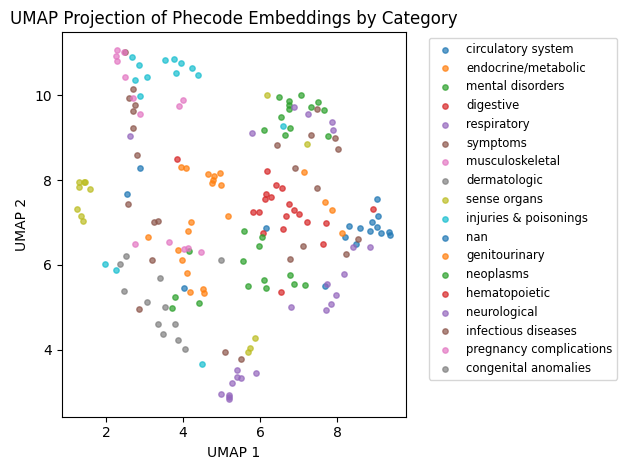

<Figure size 640x480 with 0 Axes>

In [31]:
%matplotlib inline
%run UMAP_vis.py 

## Forecasting (auto‐regressive and time‐specific) 

TrajGPT supports two inference strategies for forecasting. 

1. Auto-Regressive Inference: Just like a standard GPT, we generate one token at a time in a causal loop using the previous hidden states. 


2. Time-Specific Inference. It leverages the ODE's property, it can directly predict arbitrary future timestamps using the final observed hidden states. 


To switch between these modes, modify the `--forecast_method` flag in the argument parser:
```
    parser.add_argument('--forecast_method', type=str, default='time_specific',
                        help='forecasting implementation, options:[time_specific, auto_regressive]')
```